In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
import time
from sklearn.metrics import mean_squared_error

'''
None || 20000 || 100000
'''
nb = None
nb_trains = nb
nb_valids = nb
nb_tests = nb

N_past = 10

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
# cd drive/MyDrive/Projects/JPX_Tokyo_Stock/JPX_stock_2022/working

/content/drive/MyDrive/Projects/JPX_Tokyo_Stock/JPX_stock_2022/working


In [ ]:
! pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 308 kB 5.0 MB/s 
     |████████████████████████████████| 81 kB 9.2 MB/s 
     |████████████████████████████████| 209 kB 93.9 MB/s 
     |████████████████████████████████| 78 kB 8.1 MB/s 
     |████████████████████████████████| 49 kB 7.1 MB/s 
     |████████████████████████████████| 112 kB 64.1 MB/s 
     |████████████████████████████████| 147 kB 10.2 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=44939d0f15374ff18fd41544407fadd5d797fdebf34679a794330e17352a4e23
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


In [ ]:
import optuna
from data_utils import *

#### Load Data

In [ ]:
train_df = pd.read_csv('../__input__/2_FeatureEngineering/train_df.csv', parse_dates=['Date'], nrows = nb_trains)
valid_df = pd.read_csv('../__input__/2_FeatureEngineering/valid_df.csv', parse_dates=['Date'], nrows = nb_trains)
test_df = pd.read_csv('../__input__/2_FeatureEngineering/test_df.csv', parse_dates=['Date'], nrows = nb_trains)

In [ ]:
mini_train_DP = pd.read_csv('../__input__/1_DataPreprocessing/mini_train.csv', parse_dates=['Date'], nrows = None)
mini_train_FE = pd.read_csv('../__input__/2_FeatureEngineering/mini_train.csv', parse_dates=['Date'], nrows = None)

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1843182 entries, 0 to 1843181
Data columns (total 64 columns):
 #   Column            Dtype         
---  ------            -----         
 0   Date              datetime64[ns]
 1   SecuritiesCode    int64         
 2   ExpectedDividend  float64       
 3   AdjustmentFactor  float64       
 4   SupervisionFlag   bool          
 5   Volume            float64       
 6   Close             float64       
 7   Target            float64       
 8   CloseT1           float64       
 9   CloseT2           float64       
 10  Range_HL          float64       
 11  Range_OC          float64       
 12  dayofyear         int64         
 13  dayofweek         int64         
 14  week              int64         
 15  is_month_end      bool          
 16  is_month_start    bool          
 17  is_year_end       bool          
 18  is_year_start     bool          
 19  Year              int64         
 20  Month             int64         
 21  Day     

In [ ]:
valid_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232663 entries, 0 to 232662
Data columns (total 64 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   Date              232663 non-null  datetime64[ns]
 1   SecuritiesCode    232663 non-null  int64         
 2   ExpectedDividend  232663 non-null  float64       
 3   AdjustmentFactor  232663 non-null  float64       
 4   SupervisionFlag   232663 non-null  bool          
 5   Volume            232663 non-null  float64       
 6   Close             232663 non-null  float64       
 7   Target            232663 non-null  float64       
 8   CloseT1           232663 non-null  float64       
 9   CloseT2           232663 non-null  float64       
 10  Range_HL          232663 non-null  float64       
 11  Range_OC          232663 non-null  float64       
 12  dayofyear         232663 non-null  int64         
 13  dayofweek         232663 non-null  int64         
 14  week

In [ ]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 198663 entries, 0 to 198662
Data columns (total 64 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   Date              198663 non-null  datetime64[ns]
 1   SecuritiesCode    198663 non-null  int64         
 2   ExpectedDividend  198663 non-null  float64       
 3   AdjustmentFactor  198663 non-null  float64       
 4   SupervisionFlag   198663 non-null  bool          
 5   Volume            198663 non-null  float64       
 6   Close             198663 non-null  float64       
 7   Target            198663 non-null  float64       
 8   CloseT1           198663 non-null  float64       
 9   CloseT2           198663 non-null  float64       
 10  Range_HL          198663 non-null  float64       
 11  Range_OC          198663 non-null  float64       
 12  dayofyear         198663 non-null  int64         
 13  dayofweek         198663 non-null  int64         
 14  week

### Calc Scores

In [ ]:
def calc_spread_return_per_day(df, portfolio_size: int = 200, toprank_weight_ratio: float = 2):
    """
    Args:
        df (pd.DataFrame): predicted results
        portfolio_size (int): # of equities to buy/sell
        toprank_weight_ratio (float): the relative weight of the most highly ranked stock compared to the least.
    Returns:
        (float): spread return
    """
    assert df['Rank'].min() == 0
    assert df['Rank'].max() == len(df['Rank']) - 1
    weights = np.linspace(start=toprank_weight_ratio, stop=1, num=portfolio_size)
    purchase = (df.sort_values(by='Rank')['Target'][:portfolio_size] * weights).sum() / weights.mean()
    short = (df.sort_values(by='Rank', ascending=False)['Target'][:portfolio_size] * weights).sum() / weights.mean()
    return purchase - short

def calc_spread_return_sharpe(df: pd.DataFrame, portfolio_size: int = 200, toprank_weight_ratio: float = 2) -> float:
    """
    Args:
        df (pd.DataFrame): predicted results
        portfolio_size (int): # of equities to buy/sell
        toprank_weight_ratio (float): the relative weight of the most highly ranked stock compared to the least.
    Returns:
        (float): sharpe ratio
    """
    buf = df.groupby('Date').apply(calc_spread_return_per_day, portfolio_size, toprank_weight_ratio)
    sharpe_ratio = buf.mean() / buf.std()
    return sharpe_ratio, buf

def add_rank(df: pd.DataFrame, y_pred):
    df["Pred"] = y_pred
    df["Rank"] = df.groupby("Date")["Pred"].rank(ascending=False, method="first") - 1 
    df = df.drop("Pred", axis= 1)
    return df

In [ ]:
def calc_score(df: pd.DataFrame, y_pred: pd.DataFrame, y_true: pd.DataFrame, render_info= True):
    feature_df = df.copy()
    feature_df = add_rank(feature_df, y_pred)
    feature_df['Target'] = y_true
    score, buf = calc_spread_return_sharpe(feature_df)
    if render_info:
        print(f'score -> {score}\nmean -> {buf.mean()}\nstd -> {buf.std()}')
    del feature_df
    return score

In [ ]:
calc_score(test_df, test_df["Target"], test_df["Target"])

score -> 4.7366694709759
mean -> 15.115996128121251
std -> 3.1912710440838277


4.7366694709759

### Cross Validation

In [ ]:
featureCols = train_df.drop(["Target", "CloseT1", "CloseT2"], axis = 1).columns
featureCols

Index(['Date', 'SecuritiesCode', 'ExpectedDividend', 'AdjustmentFactor',
       'SupervisionFlag', 'Volume', 'Close', 'Range_HL', 'Range_OC',
       'dayofyear', 'dayofweek', 'week', 'is_month_end', 'is_month_start',
       'is_year_end', 'is_year_start', 'Year', 'Month', 'Day', 'Close_lags_1',
       'Range_HL_lags_1', 'Range_OC_lags_1', 'Volume_lags_1', 'Close_lags_2',
       'Range_HL_lags_2', 'Range_OC_lags_2', 'Volume_lags_2', 'Close_lags_3',
       'Range_HL_lags_3', 'Range_OC_lags_3', 'Volume_lags_3', 'Close_lags_4',
       'Range_HL_lags_4', 'Range_OC_lags_4', 'Volume_lags_4', 'Close_lags_5',
       'Range_HL_lags_5', 'Range_OC_lags_5', 'Volume_lags_5', 'Close_lags_6',
       'Range_HL_lags_6', 'Range_OC_lags_6', 'Volume_lags_6', 'Close_lags_7',
       'Range_HL_lags_7', 'Range_OC_lags_7', 'Volume_lags_7', 'Close_lags_8',
       'Range_HL_lags_8', 'Range_OC_lags_8', 'Volume_lags_8', 'Close_lags_9',
       'Range_HL_lags_9', 'Range_OC_lags_9', 'Volume_lags_9', 'Close_lags_10',
 

In [ ]:
X_train = train_df[featureCols]
X_train["Date"] = X_train["Date"].astype(str)
y_train = train_df["Target"]

X_valid = valid_df[featureCols]
X_valid["Date"] = X_valid["Date"].astype(str)
y_valid = valid_df["Target"]

X_test = test_df[featureCols]
X_test["Date"] = X_test["Date"].astype(str)
yTest_true = test_df["Target"]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/

In [ ]:
calc_score(X_test, yTest_true, yTest_true)

score -> 4.7366694709759
mean -> 15.115996128121251
std -> 3.1912710440838277


4.7366694709759

#### Optuna tuning

In [ ]:
def objective(
    trial,
    random_state=22,
    n_jobs=-1,
):
    # XGBoost parameters
    params = {
        'tree_method':'gpu_hist',
        "verbosity": 0,  # 0 (silent) - 3 (debug)
        "objective": "reg:squarederror",
        "n_estimators": trial.suggest_int("n_estimators", 5, 10) * 100,
        "max_depth": trial.suggest_int("max_depth", 4, 20),
        "learning_rate": trial.suggest_loguniform("learning_rate", 0.005, 0.05),
        "colsample_bytree": trial.suggest_loguniform("colsample_bytree", 0.2, 0.6),
        "subsample": trial.suggest_loguniform("subsample", 0.6, 0.8),
        "alpha": trial.suggest_loguniform("alpha", 0.01, 10.0),
        "lambda": trial.suggest_loguniform("lambda", 1e-8, 10.0),
        "gamma": trial.suggest_loguniform("lambda", 1e-8, 10.0),
        "min_child_weight": trial.suggest_loguniform("min_child_weight", 10, 1000),
        "seed": random_state,
        "n_jobs": n_jobs,
        "early_stopping_rounds": 50,
        "eval_metric": "rmse"
        
    }
    
    model = xgb.XGBRegressor(**params) 

    model.fit(
        X_train.drop("Date", axis = 1),
        y_train,
        eval_set=[(X_valid.drop("Date", axis = 1), y_valid)],
        verbose=0,
    )
    y_pred = pd.DataFrame(model.predict(X_valid.drop("Date", axis = 1)), columns =['Target'])
    return calc_score(X_valid, y_pred, y_valid, render_info= False)

In [ ]:
%%time
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

[I 2022-07-20 00:58:30,574] A new study created in memory with name: no-name-ef5d9f2a-493e-4a4b-ab63-15ee0087a98f
[I 2022-07-20 00:59:03,859] Trial 0 finished with value: 0.15000313759537068 and parameters: {'n_estimators': 5, 'max_depth': 4, 'learning_rate': 0.021021661074885827, 'colsample_bytree': 0.36851707463448463, 'subsample': 0.6266570684964355, 'alpha': 0.8298100546710911, 'lambda': 5.017379582701743e-06, 'min_child_weight': 393.6376966574984}. Best is trial 0 with value: 0.15000313759537068.
[I 2022-07-20 01:00:11,903] Trial 1 finished with value: 0.18851695943464214 and parameters: {'n_estimators': 7, 'max_depth': 11, 'learning_rate': 0.028930218553966245, 'colsample_bytree': 0.5750599592017832, 'subsample': 0.7097357691137528, 'alpha': 0.1971914552899138, 'lambda': 1.143740002941748e-08, 'min_child_weight': 578.5394746577219}. Best is trial 1 with value: 0.18851695943464214.
[I 2022-07-20 01:01:50,852] Trial 2 finished with value: 0.21713465858500314 and parameters: {'n_est

Number of finished trials: 30
Best trial: {'n_estimators': 10, 'max_depth': 15, 'learning_rate': 0.015107646108550874, 'colsample_bytree': 0.27525012231668355, 'subsample': 0.6895054632161345, 'alpha': 0.03121626887114335, 'lambda': 0.000415355382658415, 'min_child_weight': 20.815622011274296}
CPU times: user 1h 29min 33s, sys: 55.8 s, total: 1h 30min 29s
Wall time: 1h 30min 5s


In [ ]:
# best_params = {
# 'max_depth': 19, 
# 'learning_rate': 0.025941339430375736, 
# 'colsample_bytree': 0.23703603495974382, 
# 'subsample': 0.623891935763922, 
# 'alpha': 0.011194397798498705, 
# 'lambda': 5.016592593209065e-08, 
# 'min_child_weight': 10.273750710892847,
#  'early_stopping_rounds': 50,
#  'eval_metric': 'rmse',
#  'n_estimators': 1000,
#  'n_jobs': -1,
#  'objective': 'reg:squarederror',
#  'seed': 22,
#  'tree_method': 'gpu_hist',
#  'verbosity': 0}

# best_params

In [ ]:
best_params = study.best_trial.params
best_params['n_estimators'] *= 100

best_params['tree_method'] = 'gpu_hist'
best_params['verbosity'] = 0
best_params['objective'] = "reg:squarederror"
best_params['seed'] = 22
best_params['n_jobs'] = -1
best_params["early_stopping_rounds"] = 50
best_params["eval_metric"] = "rmse"

best_params

{'alpha': 0.03121626887114335,
 'colsample_bytree': 0.27525012231668355,
 'early_stopping_rounds': 50,
 'eval_metric': 'rmse',
 'lambda': 0.000415355382658415,
 'learning_rate': 0.015107646108550874,
 'max_depth': 15,
 'min_child_weight': 20.815622011274296,
 'n_estimators': 1000,
 'n_jobs': -1,
 'objective': 'reg:squarederror',
 'seed': 22,
 'subsample': 0.6895054632161345,
 'tree_method': 'gpu_hist',
 'verbosity': 0}

In [ ]:
%%time
model = xgb.XGBRegressor(**best_params) 

model.fit(
    X_train.drop("Date", axis = 1),
    y_train,
    eval_set=[(X_valid.drop("Date", axis = 1), y_valid)],
    verbose=0,
)

CPU times: user 4min 12s, sys: 1.7 s, total: 4min 14s
Wall time: 4min 13s


In [ ]:
%%time
y_pred = pd.DataFrame(model.predict(X_train.drop("Date", axis = 1)), columns =['Target'])
print(calc_score(X_train, y_pred, y_train, render_info= False))

3.8921991113597705
CPU times: user 13.6 s, sys: 1.33 s, total: 14.9 s
Wall time: 14.8 s


In [ ]:
np.sqrt(mean_squared_error(y_pred, y_train))

0.017113496108677736

In [ ]:
%%time
y_pred = pd.DataFrame(model.predict(X_valid.drop("Date", axis = 1)), columns =['Target'])
print(calc_score(X_valid, y_pred, y_valid, render_info= False))

0.2585777768849355
CPU times: user 1.66 s, sys: 163 ms, total: 1.82 s
Wall time: 1.81 s


In [ ]:
np.sqrt(mean_squared_error(y_pred, y_valid))

0.021426365407683952

In [ ]:
%%time
y_pred = pd.DataFrame(model.predict(X_test.drop("Date", axis = 1)), columns =['Target'])
print(calc_score(X_test, y_pred, yTest_true, render_info= False))

0.12102818230523413
CPU times: user 1.43 s, sys: 155 ms, total: 1.59 s
Wall time: 1.58 s


In [ ]:
np.sqrt(mean_squared_error(y_pred, yTest_true))

0.024571998744342165

In [ ]:
def render_feature_important(model_xgboost, df_trained):
  feature_important = model_xgboost.feature_importances_
  sorted_idx = np.argsort(feature_important)[::-1]

  keys = df_trained.columns[sorted_idx]
  values = feature_important[sorted_idx]

  data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=True)
  data.plot(kind='barh', figsize = (20,10))

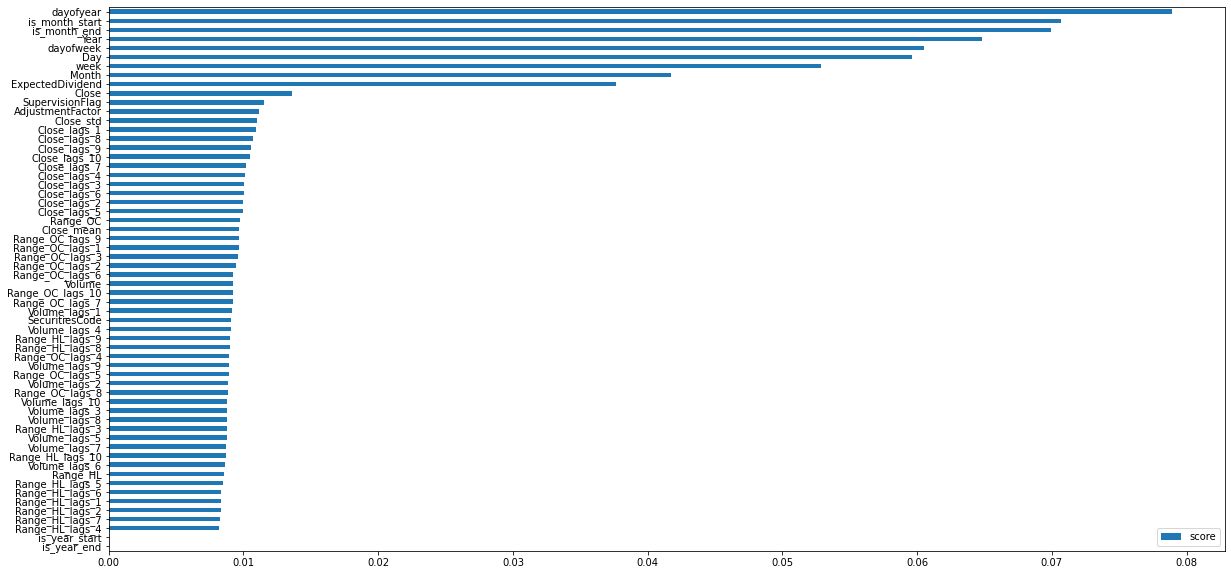

In [ ]:
render_feature_important(model, X_train.drop("Date", axis = 1))